## Import Modules

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import time
import umap

## Hyperparameters

In [2]:
NAME = "GraphTransformer"
LATENT_DIM = 16
BATCH_SIZE = 128
EPOCHS = 1000
LEARNING_RATE = 1e-4
BETA = 0.0025
WEIGHT_DECAY = 1e-5
GRADIENT_CLIPPING = False
CLIP_VALUE = 100
STD_DEV_MEASURE_MOD = 50
STD_DEV_MEASURE_SCALE = 1
LOSS_REDUCTION = "mean"    # sum or mean

BETA_CYCLES = 3

TRAIN_RATIO = 0.8

## Definitions

In [3]:
def plot_mean_features(df_encoded):
    feature_means = df_encoded.mean()

    plt.figure(figsize=(12, 6))
    plt.plot(feature_means, marker='o', linestyle='-', markersize=3)
    plt.xlabel("Feature Index")
    plt.ylabel("Average Value")
    plt.title("Average Value of Each Feature")
    plt.grid(True)
    plt.show()

In [4]:
mse_loss = nn.MSELoss(reduction=LOSS_REDUCTION)
bce_loss = nn.BCELoss(reduction=LOSS_REDUCTION)
ce_loss = nn.CrossEntropyLoss(reduction=LOSS_REDUCTION)
algo_loss = nn.CrossEntropyLoss(reduction=LOSS_REDUCTION)

def vae_total_loss(pred, target, be_mask, ce_mask, mse_mask, alg_mask, mu, logvar, beta):
    assert not torch.isnan(pred).any()

    device = pred.device
    be_mask = be_mask.to(device)
    ce_mask = ce_mask.to(device)
    mse_mask = mse_mask.to(device)
    alg_mask = alg_mask.to(device)

    # --------------------
    # BCE (binary features)
    # --------------------
    if be_mask.any():
        bce_loss = F.binary_cross_entropy_with_logits(
            pred[:, be_mask],
            target[:, be_mask],
            reduction="mean"
        )
    else:
        bce_loss = torch.tensor(0.0, device=device)

    # --------------------
    # MSE (continuous features)
    # --------------------
    if mse_mask.any():
        mse_loss = F.mse_loss(
            pred[:, mse_mask],
            target[:, mse_mask],
            reduction="mean"
        )
    else:
        mse_loss = torch.tensor(0.0, device=device)

    # --------------------
    # CE (single categorical group)
    # --------------------
    if ce_mask.any():
        ce_logits = pred[:, ce_mask]
        ce_targets = target[:, ce_mask]

        ce_target_idx = ce_targets.argmax(dim=1)

        ce_loss = F.cross_entropy(
            ce_logits,
            ce_target_idx.long(),
            reduction="mean"
        )
    else:
        ce_loss = torch.tensor(0.0, device=device)

    # --------------------
    # Algorithm Loss (single categorical group)
    # --------------------
    if alg_mask.any():
        ce_logits = pred[:, alg_mask]
        alg_targets = target[:, alg_mask]

        alg_target_idx = alg_targets.argmax(dim=1)

        alg_loss = F.cross_entropy(
            ce_logits,
            alg_target_idx.long(),
            reduction="mean"
        )
    else:
        alg_loss = torch.tensor(0.0, device=device)

    # --------------------
    # Total MSE (normalized for all feature types)
    # --------------------
    total_mse_vals = []

    if mse_mask.any():
        total_mse_vals.append(pred[:, mse_mask] - target[:, mse_mask])

    if be_mask.any():
        total_mse_vals.append(torch.sigmoid(pred[:, be_mask]) - target[:, be_mask])

    if ce_mask.any():
        total_mse_vals.append(torch.sigmoid(pred[:, ce_mask]) - target[:, ce_mask])

    # Helper to find contiguous True slices in a mask
    def mask_slices(mask):
        mask = mask.cpu().numpy().astype(int)
        slices = []
        start = None
        for i, val in enumerate(mask):
            if val and start is None:
                start = i
            elif not val and start is not None:
                slices.append((start, i))
                start = None
        if start is not None:
            slices.append((start, len(mask)))
        return slices

    # Categorical features ('c' and 'x'): apply softmax per contiguous slice
    if alg_mask.any():
        for start, end in mask_slices(alg_mask):
            probs = F.softmax(pred[:, start:end], dim=-1)
            total_mse_vals.append(probs - target[:, start:end])

    # Combine all and compute MSE
    if total_mse_vals:
        total_mse_tensor = torch.cat(total_mse_vals, dim=1)
        total_mse = torch.mean(total_mse_tensor**2)
    else:
        total_mse = torch.tensor(0.0, device=pred.device)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
    # free bits (forces KL to stay above some minimum value)
    kl_loss = torch.mean(torch.clamp(kl_loss, min=0.01)) # original minimum was 0.1

    total_loss = bce_loss + ce_loss + mse_loss + beta * kl_loss + alg_loss
    return total_loss, mse_loss, ce_loss, bce_loss, beta * kl_loss, total_mse, alg_loss

In [5]:
def warmup(epoch, max_epoch, rate, max_beta):
    y = min(rate * epoch, rate * max_epoch)
    y = min(y, max_beta)
    return y

def cyclic_beta_schedule(epoch, max_beta, period=100):
    # see: https://www.microsoft.com/en-us/research/blog/less-pain-more-gain-a-simple-method-for-vae-training-with-less-of-that-kl-vanishing-agony/
    half_period = period // 2
    i = epoch % period
     # hold at max for last half of period
    if i > half_period: return max_beta       
     # grow to max for first half of period
    return i / half_period * max_beta
    
def train_model(vae, masks, train_dataloader, val_dataloader, device, debug=False):
    mse_mask, be_mask, ce_mask, alg_mask = masks

    # register hook for gradient clipping
    if GRADIENT_CLIPPING:
        for param in vae.parameters():
            param.register_hook(lambda grad: torch.clamp(grad, -CLIP_VALUE, CLIP_VALUE))
    
    # use AdamW instead as Adam is broken
    optimizer = torch.optim.AdamW(vae.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE,
        pct_start=0.0,
        steps_per_epoch=len(train_dataloader),
        epochs=EPOCHS
    )
    
    train_losses, train_mse_recon_losses, train_ce_recon_losses, train_kl_losses, train_be_recon_losses, train_algo_recon_losses  = [], [], [], [], [], []
    val_losses, val_mse_recon_losses, val_ce_recon_losses, val_kl_losses, val_be_recon_losses, val_algo_recon_losses = [], [], [], [], [], []

    for epoch in range(EPOCHS):
        start_time = time.time()
        train_epoch_total_loss = 0
        train_epoch_mse_recon_loss = 0
        train_epoch_ce_recon_loss = 0
        train_epoch_be_recon_loss = 0
        train_epoch_kl_loss = 0
        train_sparsity_loss = 0
        train_epoch_algo_loss = 0
        train_total_mse_loss = 0

        val_epoch_total_loss = 0
        val_epoch_mse_recon_loss = 0
        val_epoch_ce_recon_loss = 0
        val_epoch_be_recon_loss = 0
        val_epoch_kl_loss = 0
        val_epoch_sparsity_loss = 0
        val_epoch_algo_loss = 0
        val_total_mse_loss = 0
        if epoch % STD_DEV_MEASURE_MOD == 0:
            plt.clf()
            
        beta = cyclic_beta_schedule(epoch, BETA, period=(EPOCHS // BETA_CYCLES))

        vae.train()
        for batch in train_dataloader:
            x_batch = batch[0].to(device)
            
            recon_x, mu, logvar, tup = vae(x_batch)

            train_total_loss, train_mse_recon_loss, train_ce_recon_loss, train_be_recon_loss, train_kl_loss, total_mse, alg_loss = vae_total_loss(
                recon_x,
                x_batch,
                be_mask,
                ce_mask,
                mse_mask,
                alg_mask,
                mu,
                logvar,
                beta
            )

            # train_total_loss += alg_loss

            optimizer.zero_grad()
            train_total_loss.backward()
            optimizer.step()
            scheduler.step()

            train_epoch_total_loss += train_total_loss.item()
            train_epoch_mse_recon_loss += train_mse_recon_loss.item()
            train_epoch_ce_recon_loss += train_ce_recon_loss.item()
            train_epoch_be_recon_loss += train_be_recon_loss.item()
            train_epoch_kl_loss += train_kl_loss.item()
            train_epoch_algo_loss += alg_loss.item()
            #train_sparsity_loss += sparsity_loss.item()
            train_total_mse_loss += total_mse.item()

        vae.eval() # <- mode for just evaluating
        with torch.no_grad(): # <- don't track gradients
            for batch in val_dataloader:
                x_batch = batch[0].to(device)
                recon_x, mu, logvar, tup = vae(x_batch)
                val_total_loss, val_mse_recon_loss, val_ce_recon_loss, val_be_recon_loss, val_kl_loss, val_mse_total, alg_loss = vae_total_loss(
                    recon_x,
                    x_batch,
                    be_mask,
                    ce_mask,
                    mse_mask,
                    alg_mask,
                    mu,
                    logvar,
                    beta,
                )

                #val_total_loss += alg_loss

                val_epoch_total_loss += val_total_loss.item()
                val_epoch_mse_recon_loss += val_mse_recon_loss.item()
                val_epoch_ce_recon_loss += val_ce_recon_loss.item()
                val_epoch_be_recon_loss += val_be_recon_loss.item()
                val_epoch_kl_loss += val_kl_loss.item()
                val_total_mse_loss += val_mse_total.item()
                val_epoch_algo_loss += alg_loss.item()
                #val_epoch_sparsity_loss += sparsity_loss

        if epoch % STD_DEV_MEASURE_MOD == 0:
            plt.savefig(f"graph/outputs_{epoch//STD_DEV_MEASURE_MOD:08d}.png")

        train_avg_total_loss = train_epoch_total_loss           / len(train_dataloader)
        train_avg_mse_recon_loss = train_epoch_mse_recon_loss   / len(train_dataloader)
        train_avg_ce_recon_loss = train_epoch_ce_recon_loss     / len(train_dataloader)
        train_avg_be_recon_loss = train_epoch_be_recon_loss     / len(train_dataloader)
        train_avg_kl_loss = train_epoch_kl_loss                 / len(train_dataloader)
        train_avg_algo_loss = train_epoch_algo_loss             / len(train_dataloader)
        #train_avg_sparsity_loss = train_sparsity_loss           / len(train_dataloader)
        train_avg_epoch_mse_loss = train_total_mse_loss         / len(train_dataloader)

        train_losses.append(train_avg_total_loss)
        train_mse_recon_losses.append(train_avg_mse_recon_loss)
        train_ce_recon_losses.append(train_avg_ce_recon_loss)
        train_be_recon_losses.append(train_avg_be_recon_loss)
        train_algo_recon_losses.append(train_avg_algo_loss)

        train_kl_losses.append(train_avg_kl_loss)

        val_avg_total_loss = val_epoch_total_loss               / len(val_dataloader)
        val_avg_mse_recon_loss = val_epoch_mse_recon_loss       / len(val_dataloader)
        val_avg_ce_recon_loss = val_epoch_ce_recon_loss         / len(val_dataloader)
        val_avg_be_recon_loss = val_epoch_be_recon_loss         / len(val_dataloader)
        val_avg_kl_loss = val_epoch_kl_loss                     / len(val_dataloader)
        val_avg_algo_loss = val_epoch_algo_loss                 / len(val_dataloader)
        #val_avg_sparsity_loss = val_epoch_sparsity_loss         / len(val_dataloader)
        val_avg_epoch_mse_loss = val_total_mse_loss             / len(val_dataloader)

        val_losses.append(val_avg_total_loss)
        val_mse_recon_losses.append(val_avg_mse_recon_loss)
        val_ce_recon_losses.append(val_avg_ce_recon_loss)
        val_be_recon_losses.append(val_avg_be_recon_loss)
        val_algo_recon_losses.append(val_avg_algo_loss)
        val_kl_losses.append(val_avg_kl_loss)

        end_time = time.time()
        runtime = end_time - start_time
        
        if debug:
            print("-" * 50)
            print(f"Epoch {epoch+1}/{EPOCHS} done in {runtime:.4f} seconds")
            print(f"Beta: {beta:.4f}")
            print(f"Learning Rate: {scheduler.get_last_lr()[0]:.8f}")
            
            print(f"Training Loss: {train_avg_total_loss:.4f}")
            print(f"\tTraining MSE Reconstruction Loss: {train_avg_mse_recon_loss:.4f}")
            print(f"\tTraining CE Reconstruction Loss: {train_avg_ce_recon_loss:.4f}")
            print(f"\tTraining BE Reconstruction Loss: {train_avg_be_recon_loss:.4f}")
            print(f"\tTraining Algorithm Loss: {train_avg_algo_loss:.4f}")
            print(f"\tTraining KL Loss: {train_avg_kl_loss:.4f}")
            #print(f"\tTraining Sparsity Loss: {train_avg_sparsity_loss:.4f}")
            print(f"\tTraining Total MSE Reconstruction Loss: {train_avg_epoch_mse_loss:.4f}")

            print(f"Validation Loss: {val_avg_total_loss:.4f}")
            print(f"\tValidation MSE Reconstruction Loss: {val_avg_mse_recon_loss:.4f}")
            print(f"\tValidation CE Reconstruction Loss: {val_avg_ce_recon_loss:.4f}")
            print(f"\tValidation BE Reconstruction Loss: {val_avg_be_recon_loss:.4f}")
            print(f"\tValidation Algorithm Loss: {val_avg_algo_loss:.4f}")
            print(f"\tValidation KL Loss: {val_avg_kl_loss:.4f}")
            #print(f"\tValidation Sparsity Loss: {val_avg_sparsity_loss:.4f}")
            print(f"\tValidation Total MSE Reconstruction Loss: {val_avg_epoch_mse_loss:.4f}")

            print("-" * 50)

    return vae, train_losses, train_mse_recon_losses, train_ce_recon_losses, train_kl_losses, train_be_recon_losses, train_algo_recon_losses, val_losses, val_mse_recon_losses, val_ce_recon_losses, val_be_recon_losses, val_kl_losses, val_algo_recon_losses

In [6]:
def plot_loss(train_losses, train_mse_recon_losses, train_ce_recon_losses, train_kl_losses, train_be_recon_losses, train_algo_recon_losses, val_losses, val_mse_recon_losses, val_ce_recon_losses, val_be_recon_losses, val_algo_recon_loss, val_kl_losses, name):
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 6, 1)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["training", "validation"])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 6, 2)
    plt.plot(train_mse_recon_losses)
    plt.plot(val_mse_recon_losses)
    plt.legend(["training", "validation"])
    plt.title('MSE Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 6, 3)
    plt.plot(train_ce_recon_losses)
    plt.plot(val_ce_recon_losses)
    plt.legend(["training", "validation"])
    plt.title('CE Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 6, 4)
    plt.plot(train_be_recon_losses)
    plt.plot(val_be_recon_losses)
    plt.legend(["training", "validation"])
    plt.title('BE Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 6, 6)
    plt.plot(train_kl_losses)
    plt.plot(val_kl_losses)
    plt.legend(["training", "validation"])
    plt.title('KL Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 6, 5)
    plt.plot(train_algo_recon_losses)
    plt.plot(val_algo_recon_loss)
    plt.title('Algorithm Reconstruction loss')
    plt.xlabel('Epoch')
    plt.ylabel('Standard Deviation')
    
    plt.tight_layout()
    plt.savefig(f"{name}/losses.png")
    plt.show()

In [7]:
import torch
from sklearn.decomposition import PCA

def dataset_to_numpy(dataset):
    xs = []
    ys = []

    for i in range(len(dataset)):
        x, y = dataset[i]
        xs.append(x.view(-1).numpy())   # flatten if needed
        ys.append(y)

    return np.stack(xs), np.array(ys)

def visualize_latent_space(model, dataloader, device, NAME, sample_count=1000):
    model.eval()
    
    latents = []
    labels = []
    
    with torch.no_grad():
        for sample in dataloader:
            if len(latents) > sample_count:
                break

            x = sample[0].to(device)
            _, y, _, _ = model(x)
            latents.append(y.cpu())
            #print(algorithm_label.shape) # DEBUG
            labels.append(torch.argmax(x[:, 176:176+32], dim=1).cpu())
            
    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(latents)
    plt.figure()
    cmap = plt.cm.get_cmap('nipy_spectral', 32) # also 'gist_ncar' or 'hsv'
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap)
    plt.savefig(f"{NAME}/latent_umap.png")
    plt.show()

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(latents)
    plt.figure()
    cmap = plt.cm.get_cmap('nipy_spectral', 32)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap=cmap)
    plt.savefig(f"{NAME}/latent_pca.png")
    plt.show()
    #
    # plt.figure()
    # cmap = plt.cm.get_cmap('nipy_spectral', 32)
    # plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap=cmap)
    # plt.savefig(f"{NAME}/simple_dim_1_2.png")
    # plt.show()

## Train Models

In [8]:
def model_size(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [9]:
algorithms = []
with open("E:\\Coding\\vae-main\\dx7\\dx7.algorithms", "r") as f:
    for line in f:
        size = 7
        algorithm = [[1024 for _ in range(size)] for _ in range(size)]
        edges = line.split(",")
        for edge in edges:
            start = int(edge[0]) - 1
            end = int(edge[1]) - 1

            # if start < 0 or end < 0:
            #     continue

            algorithm[start][end] = 1
        algorithms.append(algorithm)

all_graphs = []
for dist in algorithms:
    n = len(dist)
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    all_graphs.append(dist)

alibi_distances = -1 * (torch.tensor(all_graphs)) + 1
algorithms = torch.tensor(algorithms)
algorithms = algorithms.where(algorithms == 1, 0)

In [10]:
def one_hot_encode_by_type(df, p_type, c_sizes):
    df = df.copy()

    c_index = 0
    new_cols = []
    new_p_type = []

    for col, t in zip(df.columns, p_type):

        if t == 'c':
            n_cat = c_sizes[c_index]
            c_index += 1

            # One-hot encode categorical column
            dummies = pd.get_dummies(df[col], prefix=col)

            # Ensure fixed number of categories
            expected_cols = [f"{col}_{i}" for i in range(n_cat)]
            for ec in expected_cols:
                if ec not in dummies.columns:
                    dummies[ec] = 0

            dummies = dummies[expected_cols]
            new_cols.append(dummies)

            # Each new column is now binary
            if n_cat > 20:
                new_p_type.extend(['x'] * n_cat)
            else:
                new_p_type.extend(['c'] * n_cat)

        elif t == 'b':
            # Treat binary as categorical with 2 classes
            dummies = pd.get_dummies(df[col], prefix=col)
            new_cols.append(dummies)

            # Each new column is binary
            new_p_type.extend(['b'] * dummies.shape[1])

        else:  # 'n'
            new_cols.append(df[[col]])
            new_p_type.append('m')

    # Combine all columns
    result = pd.concat(new_cols, axis=1)
    return result, new_p_type

def one_hot_encode_tensor(x, p_type, c_sizes, device=None, dtype=torch.float32):
    if device is None:
        device = x.device

    B, F = x.shape
    outputs = []

    c_index = 0

    for i, t in enumerate(p_type):
        col = x[:, i]

        if t == 'n':
            outputs.append(col.unsqueeze(1).to(dtype))

        elif t == 'b':
            # Binary → 2-class one hot
            col = col.long()
            oh = F.one_hot(col, num_classes=2).to(dtype)
            outputs.append(oh)

        elif t == 'c':
            num_cat = c_sizes[c_index]
            c_index += 1

            col = col.long()
            oh = F.one_hot(col, num_classes=num_cat).to(dtype)
            outputs.append(oh)

        elif t == 'x':
            num_cat = c_sizes[c_index]
            c_index += 1

            col = col.long()
            oh = F.one_hot(col, num_classes=num_cat).to(dtype)
            outputs.append(oh)

        else:
            raise ValueError(f"Unknown p_type: {t}")

    return torch.cat(outputs, dim=1)

def decode_one_hot_tensor(x_expanded, p_type, c_sizes, device=None, dtype=torch.float32):
    if device is None:
        device = x_expanded.device

    B = x_expanded.shape[0]
    outputs = []

    cursor = 0
    c_index = 0

    for t in p_type:

        if t == 'm':
            # Numerical column → single value
            col = x_expanded[:, cursor]
            outputs.append(col.unsqueeze(1))
            cursor += 1

        elif t == 'b':
            # Binary → 2 one-hot columns → argmax
            oh = x_expanded[:, cursor:cursor+2]
            col = torch.argmax(oh, dim=1).to(dtype)
            outputs.append(col.unsqueeze(1))
            cursor += 2

        elif t == 'c':
            num_cat = c_sizes[c_index]
            c_index += 1

            oh = x_expanded[:, cursor:cursor+num_cat]
            col = torch.argmax(oh, dim=1).to(dtype)
            outputs.append(col.unsqueeze(1))
            cursor += num_cat
        else:
            raise ValueError(f"Unknown p_type: {t}")

    return torch.cat(outputs, dim=1)

single_operator = ['m'] * 11 + ['c'] * 2 + ['m'] * 4 + ['b'] * 1 + ['m'] * 3
new_p_type = [*single_operator] * 6 + ['m'] * 8 + ['c'] + ['m'] + ['b'] + ['m'] * 4 + ['b'] + ['c'] + ['m'] * 2
c_lengths = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 32, 6]

df = pd.read_csv("E:\\Coding\\vae-main\\old\\dx7_cleaned.csv")
df.drop(df.columns[0], axis=1, inplace=True)
df, new_p_type = one_hot_encode_by_type(df, new_p_type, c_sizes=c_lengths)
df = df.astype('float32')

for col in df.columns:
    if not pd.api.types.is_numeric_dtype(df[col]):
        print(f"Non-numeric column: {col}")
print("Pre-encoded shape:", df.shape)

def make_masks(feature_types):
    feature_types = torch.tensor(
        [ord(ch) for ch in feature_types], dtype=torch.int32
    )

    indicies_to_keep = [x for x in range(len(new_p_type))]

    mse_mask = feature_types == ord('m')
    be_mask  = feature_types == ord('b')
    ce_mask  = feature_types == ord('c')
    alg_mask  = feature_types == ord('x')

    mse_mask = mse_mask[indicies_to_keep]
    be_mask = be_mask[indicies_to_keep]
    ce_mask = ce_mask[indicies_to_keep]
    alg_mask  = alg_mask[indicies_to_keep]

    return mse_mask, be_mask, ce_mask, alg_mask

masks = make_masks(new_p_type)

Pre-encoded shape: (29658, 225)


In [11]:
import numpy as np
from sklearn.manifold import TSNE

encoded_data_array = df.to_numpy()
x_data = torch.tensor(encoded_data_array, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(x_data)

def latent_stuff(model, name):
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    visualize_latent_space(model, dataloader=train_dataloader, device="cuda", NAME=name)

In [12]:
import os


def train_loop(model):
    # determine device
    has_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if has_cuda else "cpu")
    if has_cuda:
        print("Using GPU")
    else:
        print("Using CPU")

    # set up dataloader
    encoded_data_array = df.to_numpy()
    x_data = torch.from_numpy(encoded_data_array).to(dtype=torch.float32)
    dataset = torch.utils.data.TensorDataset(x_data)

    train_data_count = round(len(dataset) * TRAIN_RATIO)
    val_data_count = len(dataset) - train_data_count

    print("Total samples:", len(dataset))
    print("Training samples:", train_data_count)
    print("Validation samples:", val_data_count)

    train_data, val_data = torch.utils.data.random_split(dataset, [train_data_count, val_data_count])
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

    model.to(device=device)

    print(f"{model_size(model)} Parameters")

    # train vae
    print("Training VAE...")
    vae, train_losses, train_mse_recon_losses, train_ce_recon_losses, train_kl_losses, train_be_recon_losses, train_algo_recon_losses, val_losses, val_mse_recon_losses, val_ce_recon_losses, val_be_recon_losses, val_kl_losses, val_algo_recon_loss = train_model(model, masks, train_dataloader, val_dataloader, device, debug=True)
    print("VAE complete.")

    # visualize results
    print("Plotting loss and UMAP of latent space...")
    os.makedirs(NAME, exist_ok=True)
    plot_loss(train_losses, train_mse_recon_losses, train_ce_recon_losses, train_kl_losses, train_be_recon_losses, train_algo_recon_losses, val_losses, val_mse_recon_losses, val_ce_recon_losses, val_be_recon_losses, val_algo_recon_loss, val_kl_losses, NAME)
    latent_stuff(model, NAME)

    # save the vae parameters
    torch.save(vae.state_dict(), "/model.pth")
    torch.save(vae, NAME + "/model.model")

In [13]:
LATENT_DIM = 16
BATCH_SIZE = 2048
EPOCHS = 1000
LEARNING_RATE = 1e-4
BETA = 0.001
WEIGHT_DECAY = 1e-5
GRADIENT_CLIPPING = False
CLIP_VALUE = 100
STD_DEV_MEASURE_MOD = 50

STD_DEV_MEASURE_SCALE = 1
LOSS_REDUCTION = "mean"

BETA_CYCLES = 10

In [ ]:
NAME = "GraphTransformer-Alibi-Full-Beta-0-0001"
LATENT_DIM = 16
BATCH_SIZE = 2048
EPOCHS = 1000
LEARNING_RATE = 1e-4
BETA = 0.0001
WEIGHT_DECAY = 1e-5
GRADIENT_CLIPPING = False
CLIP_VALUE = 100
STD_DEV_MEASURE_MOD = 50

STD_DEV_MEASURE_SCALE = 1
LOSS_REDUCTION = "mean"

BETA_CYCLES = 10

from GraphTransformerAlibiFull import GraphTransformerAutoencoderAlibi
model = GraphTransformerAutoencoderAlibi(input_size=21, latent_space=LATENT_DIM, d_model=128, depth=6, heads=4, mlp_dim=256, num_algorithms=32, num_global_params=67, sparsity_weight=1, reparameterization=True, algorithm_distance_matricies=alibi_distances)

train_loop(model)

In [ ]:
NAME = "GraphTransformer-Alibi-Full-Beta-0-001"
LATENT_DIM = 16
BATCH_SIZE = 2048
EPOCHS = 1000
LEARNING_RATE = 1e-4
BETA = 0.001

WEIGHT_DECAY = 1e-577
GRADIENT_CLIPPING = False
CLIP_VALUE = 100
STD_DEV_MEASURE_MOD = 50

STD_DEV_MEASURE_SCALE = 1
LOSS_REDUCTION = "mean"

BETA_CYCLES = 10

from GraphTransformerAlibiFull import GraphTransformerAutoencoderAlibi
model = GraphTransformerAutoencoderAlibi(input_size=21, latent_space=LATENT_DIM, d_model=128, depth=6, heads=4, mlp_dim=256, num_algorithms=32, num_global_params=67, sparsity_weight=1, reparameterization=True, algorithm_distance_matricies=alibi_distances)

train_loop(model)

In [ ]:
NAME = "GraphTransformer-Alibi-Full-Beta-0-1"
BETA = 0.25
BATCH_SIZE = 512
LATENT_DIM = 16
from GraphTransformerAlibiFull import GraphTransformerAutoencoderAlibi
model = GraphTransformerAutoencoderAlibi(input_size=21, latent_space=LATENT_DIM, d_model=128, depth=6, heads=4, mlp_dim=256, num_algorithms=32, num_global_params=67, sparsity_weight=1, reparameterization=True, algorithm_distance_matricies=alibi_distances)
train_loop(model)

Using GPU
Total samples: 29658
Training samples: 23726
Validation samples: 5932
1713816 Parameters
Training VAE...
--------------------------------------------------
Epoch 1/1000 done in 2.2440 seconds
Beta: 0.0000
Learning Rate: 0.00010000
Training Loss: 7.6135
	Training MSE Reconstruction Loss: 0.1685
	Training CE Reconstruction Loss: 3.2490
	Training BE Reconstruction Loss: 0.6948
	Training Algorithm Loss: 3.5011
	Training KL Loss: 0.0000
	Training Total MSE Reconstruction Loss: 0.1707
Validation Loss: 7.3708
	Validation MSE Reconstruction Loss: 0.0797
	Validation CE Reconstruction Loss: 3.2451
	Validation BE Reconstruction Loss: 0.6068
	Validation Algorithm Loss: 3.4392
	Validation KL Loss: 0.0000
	Validation Total MSE Reconstruction Loss: 0.1082
--------------------------------------------------
--------------------------------------------------
Epoch 2/1000 done in 1.8266 seconds
Beta: 0.0050
Learning Rate: 0.00010000
Training Loss: 7.3501
	Training MSE Reconstruction Loss: 0.074

In [ ]:
NAME = "GraphTransformer-Alibi-Full-Beta-0-001"
BETA = .001
BATCH_SIZE = 2048
LATENT_DIM = 16
from GraphTransformerAlibiFull import GraphTransformerAutoencoderAlibi
model = GraphTransformerAutoencoderAlibi(input_size=21, latent_space=LATENT_DIM, d_model=128, depth=6, heads=4, mlp_dim=256, num_algorithms=32, num_global_params=67, sparsity_weight=1, reparameterization=True, algorithm_distance_matricies=alibi_distances)
train_loop(model)

Using GPU
Total samples: 29658
Training samples: 23726
Validation samples: 5932
1713816 Parameters
Training VAE...
--------------------------------------------------
Epoch 1/1000 done in 1.5907 seconds
Beta: 0.0000
Learning Rate: 0.00010000
Training Loss: 6.9722
	Training MSE Reconstruction Loss: 0.5182
	Training CE Reconstruction Loss: 2.3003
	Training BE Reconstruction Loss: 0.6435
	Training Algorithm Loss: 3.5102
	Training KL Loss: 0.0000
	Training Total MSE Reconstruction Loss: 0.3649
Validation Loss: 5.9010
	Validation MSE Reconstruction Loss: 0.4226
	Validation CE Reconstruction Loss: 1.4740
	Validation BE Reconstruction Loss: 0.6001
	Validation Algorithm Loss: 3.4044
	Validation KL Loss: 0.0000
	Validation Total MSE Reconstruction Loss: 0.3110
--------------------------------------------------
--------------------------------------------------
Epoch 2/1000 done in 0.7600 seconds
Beta: 0.0000
Learning Rate: 0.00010000
Training Loss: 5.5130
	Training MSE Reconstruction Loss: 0.341

Using GPU
Total samples: 29658
Training samples: 23726
Validation samples: 5932
6769304 Parameters
Training VAE...
--------------------------------------------------
Epoch 1/1000 done in 1.6227 seconds
Beta: 0.0000
Learning Rate: 0.00010000
Training Loss: 6.2363
	Training MSE Reconstruction Loss: 0.4574
	Training CE Reconstruction Loss: 1.7939
	Training BE Reconstruction Loss: 0.6036
	Training Algorithm Loss: 3.3814
	Training KL Loss: 0.0000
	Training Total MSE Reconstruction Loss: 0.3317
Validation Loss: 4.9836
	Validation MSE Reconstruction Loss: 0.2806
	Validation CE Reconstruction Loss: 1.0283
	Validation BE Reconstruction Loss: 0.5276
	Validation Algorithm Loss: 3.1471
	Validation KL Loss: 0.0000
	Validation Total MSE Reconstruction Loss: 0.2318
--------------------------------------------------
--------------------------------------------------
Epoch 2/1000 done in 1.2128 seconds
Beta: 0.0020
Learning Rate: 0.00010000
Training Loss: 4.6682
	Training MSE Reconstruction Loss: 0.204

<Figure size 640x480 with 0 Axes>

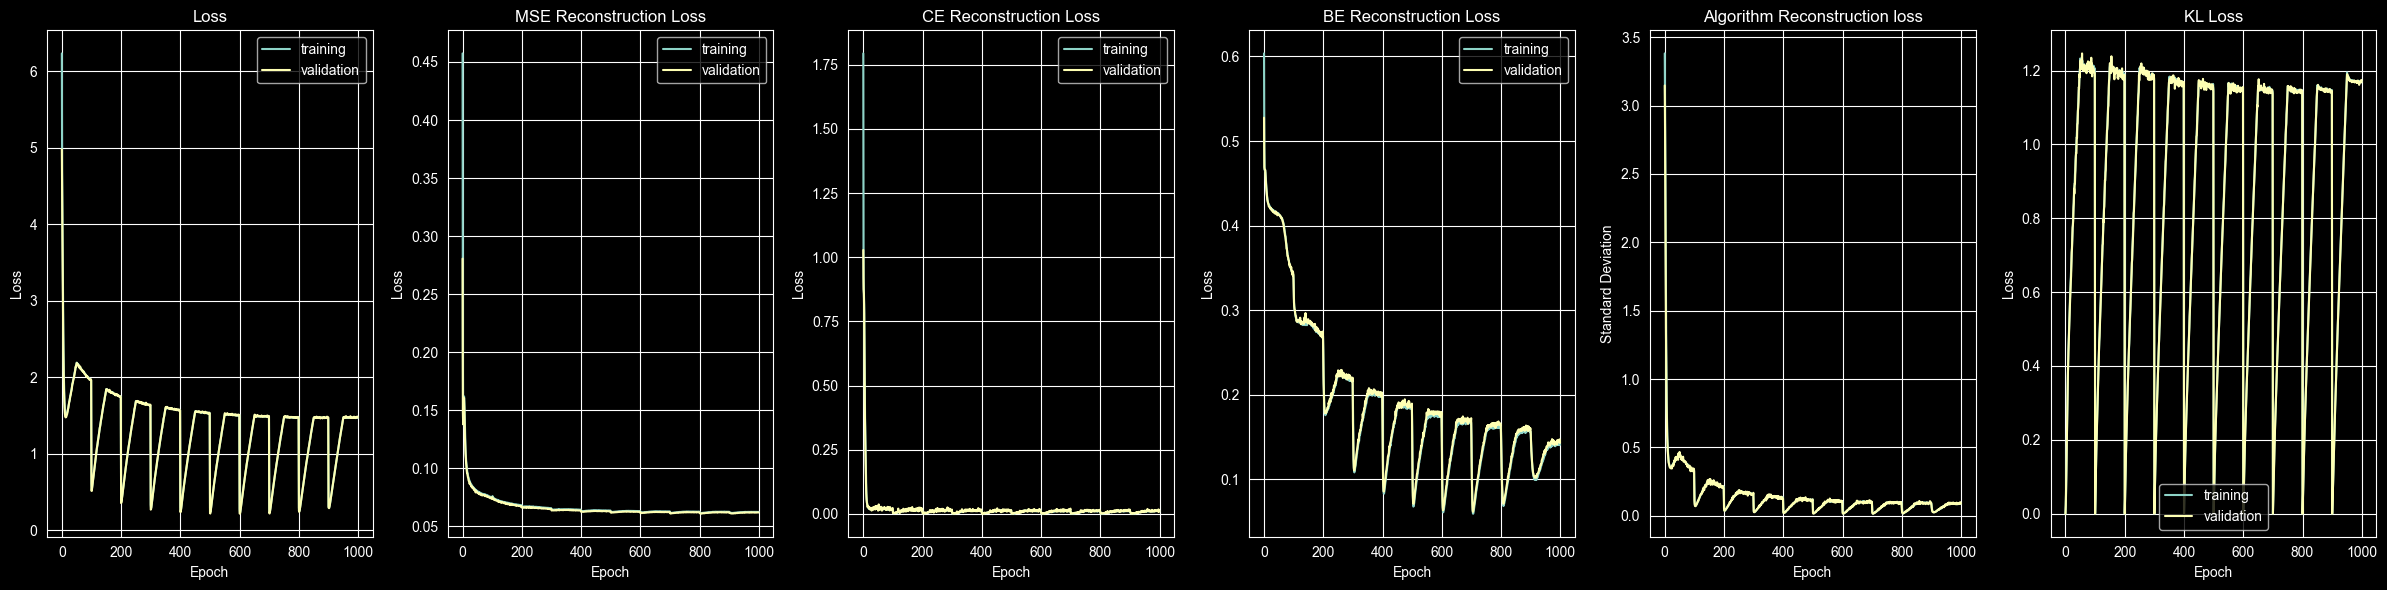

C:\Users\porda\AppData\Local\Temp\ipykernel_2692\2272073894.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32) # also 'gist_ncar' or 'hsv'


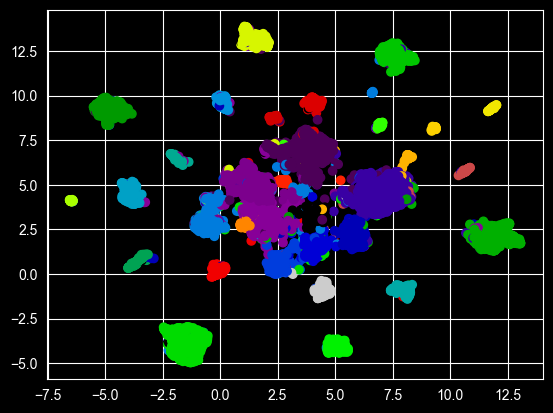

C:\Users\porda\AppData\Local\Temp\ipykernel_2692\2272073894.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32)


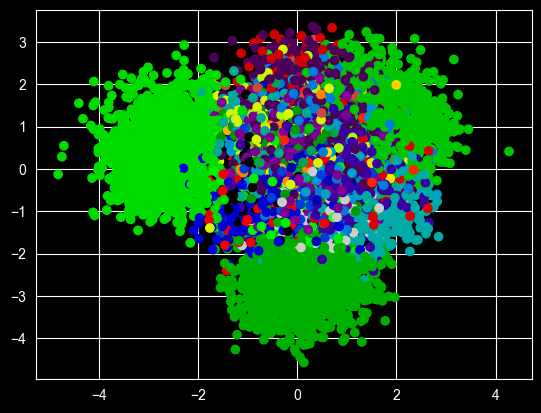

In [14]:
NAME = "GraphTransformer-Alibi-Full-Beta-0-1-big"
BETA = 0.1
BATCH_SIZE = 2048
LATENT_DIM = 16
from GraphTransformerAlibiFull import GraphTransformerAutoencoderAlibi
model = GraphTransformerAutoencoderAlibi(input_size=21, latent_space=LATENT_DIM, d_model=256, depth=6, heads=4, mlp_dim=512, num_algorithms=32, num_global_params=67, sparsity_weight=1, reparameterization=True, algorithm_distance_matricies=alibi_distances)
train_loop(model)

In [14]:
NAME = "GraphTransformer-GNN"
LATENT_DIM = 16
BATCH_SIZE = 512
EPOCHS = 1000
LEARNING_RATE = 1e-4
BETA = 0.0025
WEIGHT_DECAY = 1e-5
GRADIENT_CLIPPING = False
CLIP_VALUE = 100
STD_DEV_MEASURE_MOD = 50

STD_DEV_MEASURE_SCALE = 1
LOSS_REDUCTION = "mean"

BETA_CYCLES = 10

from GraphTransformerGNN import GraphTransformerVAE
NAME = "GraphTransformerGNN"
model = GraphTransformerVAE(input_size=21, latent_dim=LATENT_DIM, d_model=64, depth=4, heads=2, mlp_dim=128, algorithm_distance_matricies=algorithms)

train_loop(model)

AttributeError: 'GraphTransformerVAE' object has no attribute 'num_nodes'

In [ ]:
from GraphTransformerAutoencoderFIlm import GraphTransformerAutoencoder

NAME = "GraphTransformerFilm"
LATENT_DIM = 16
BATCH_SIZE = 512
EPOCHS = 1000
LEARNING_RATE = 1e-4
BETA = 0.0025
WEIGHT_DECAY = 1e-5
GRADIENT_CLIPPING = False
CLIP_VALUE = 100
STD_DEV_MEASURE_MOD = 50

STD_DEV_MEASURE_SCALE = 1
LOSS_REDUCTION = "mean"

BETA_CYCLES = 10

model = GraphTransformerAutoencoder(input_size=20, latent_space=LATENT_DIM, d_model=128, depth=6, heads=4, mlp_dim=256, num_algorithms=32, num_global_params=145 - (6 * 20) - 1, sparsity_weight=1, reparameterization=True)

train_loop(model)

225
204
183
183
162
141
141
120
100
100
79
58
58
37
16
16
37
58
58
79
100
100
120
141
141
162
183
183
204
225
Using GPU
Total samples: 29658
Training samples: 23726
Validation samples: 5932
641734 Parameters
Training VAE...
--------------------------------------------------
Epoch 1/1000 done in 1.1230 seconds
Beta: 0.0000
Learning Rate: 0.00040000
Training Loss: 7.7259
	Training MSE Reconstruction Loss: 0.1316
	Training CE Reconstruction Loss: 3.5335
	Training BE Reconstruction Loss: 0.6783
	Training Algorithm Loss: 3.3825
	Training KL Loss: 0.0000
	Training Total MSE Reconstruction Loss: 0.1684
Validation Loss: 7.1636
	Validation MSE Reconstruction Loss: 0.0888
	Validation CE Reconstruction Loss: 3.2233
	Validation BE Reconstruction Loss: 0.6027
	Validation Algorithm Loss: 3.2488
	Validation KL Loss: 0.0000
	Validation Total MSE Reconstruction Loss: 0.1347
--------------------------------------------------
--------------------------------------------------
Epoch 2/1000 done in 0.3690 

<Figure size 640x480 with 0 Axes>

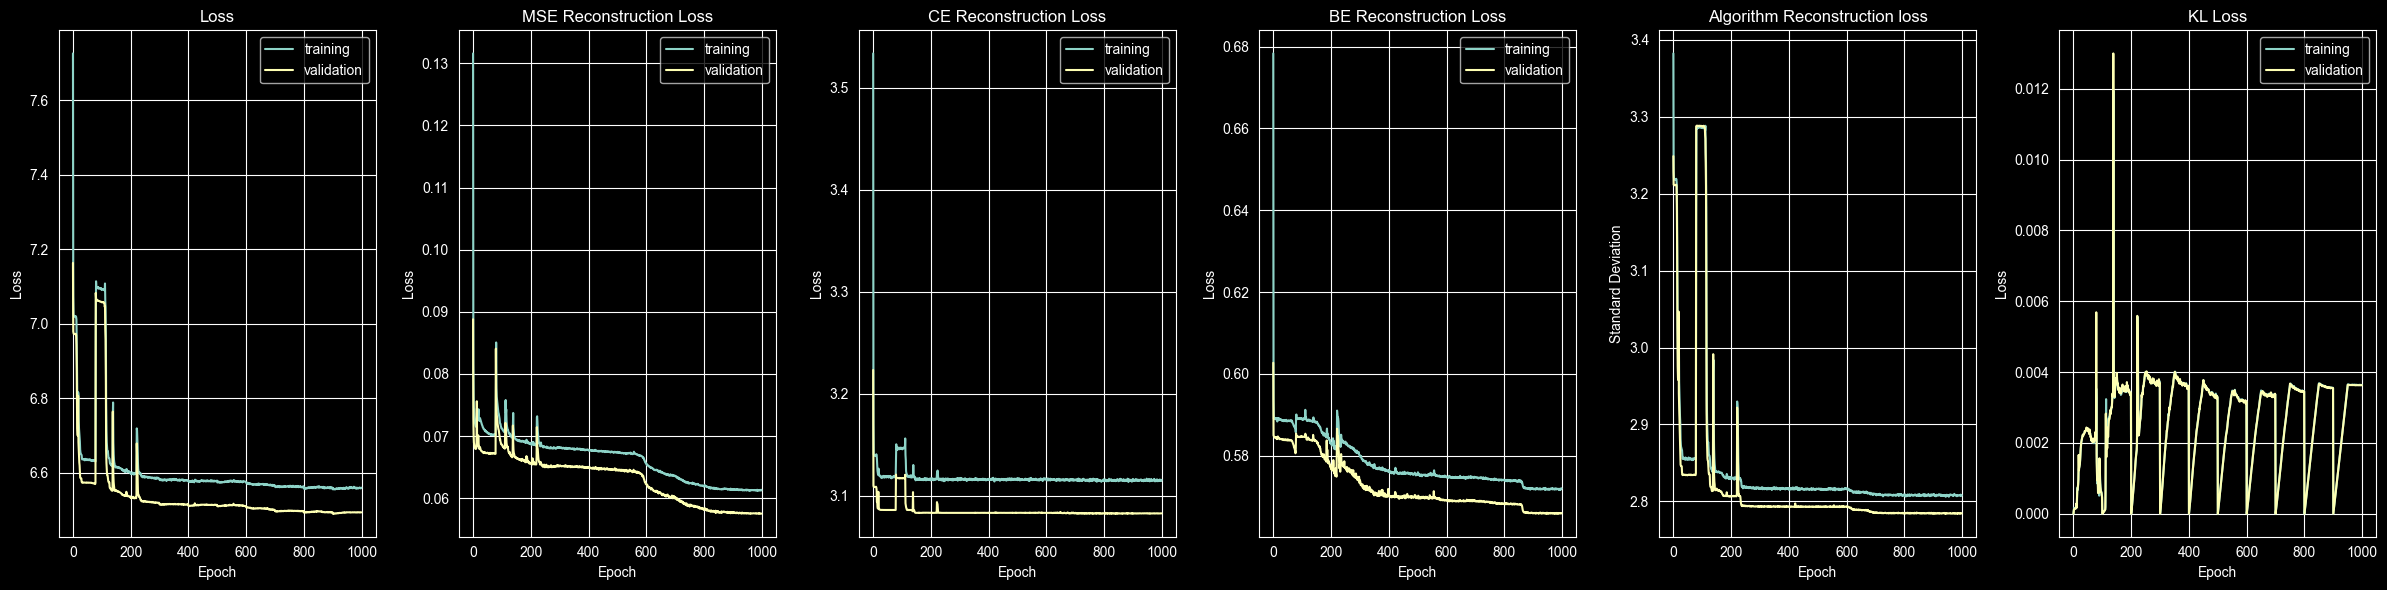

C:\Users\porda\AppData\Local\Temp\ipykernel_6172\2272073894.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32) # also 'gist_ncar' or 'hsv'


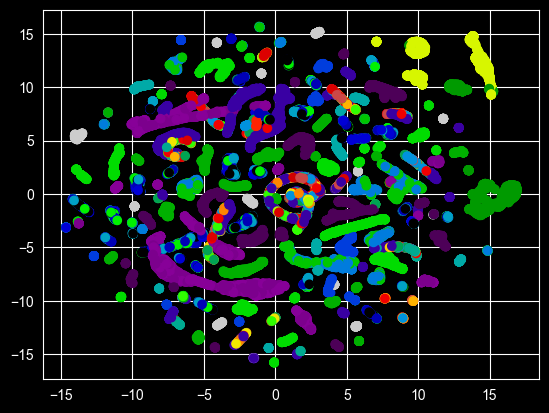

C:\Users\porda\AppData\Local\Temp\ipykernel_6172\2272073894.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32)


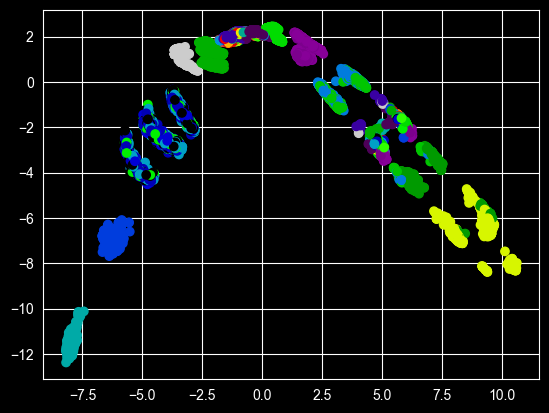

In [49]:
from GraphTransformerAutoencoderFIlm import GraphTransformerAutoencoder
from ResidualNet import VariationalAutoencoder

LATENT_DIM = 16
BATCH_SIZE = 2048
EPOCHS = 1000

LEARNING_RATE = 0.0004
BETA = 0.0001
WEIGHT_DECAY = 1e-3 #1e-6

FINAL_DIV_FACTOR = 4.0

GRADIENT_CLIPPING = False
CLIP_VALUE = 100
STD_DEV_MEASURE_MOD = 50
STD_DEV_MEASURE_SCALE = 1
LOSS_REDUCTION = "mean"                # sum or mean

DROPOUT_PROB = 0.02 #0.03

RESIDUAL_BLOCKS = 3
BETA_CYCLES = 10 #6

TRAIN_RATIO = 0.8

BUFFER = 0.1
BUFFER_RANGE = (1.0 - BUFFER) - BUFFER
BUFFER_RESCALE = 1.0 / (BUFFER_RANGE**2)

FOLDS = 5

CHECK_OVERFIT = True
MAX_OVERFIT_TIME = 25

NAME = f"VAE-{LATENT_DIM}-Beta-0-0001"

model = VariationalAutoencoder(input_dim=225, output_dim=225, latent_dim=LATENT_DIM)
train_loop(model)

225
204
183
183
162
141
141
120
100
100
79
58
58
37
16
16
37
58
58
79
100
100
120
141
141
162
183
183
204
225
Using GPU
Total samples: 29658
Training samples: 23726
Validation samples: 5932
641734 Parameters
Training VAE...
--------------------------------------------------
Epoch 1/1000 done in 0.5859 seconds
Beta: 0.0000
Learning Rate: 0.00040000
Training Loss: 7.6946
	Training MSE Reconstruction Loss: 0.1333
	Training CE Reconstruction Loss: 3.5263
	Training BE Reconstruction Loss: 0.6767
	Training Algorithm Loss: 3.3583
	Training KL Loss: 0.0000
	Training Total MSE Reconstruction Loss: 0.1682
Validation Loss: 7.1247
	Validation MSE Reconstruction Loss: 0.0847
	Validation CE Reconstruction Loss: 3.1996
	Validation BE Reconstruction Loss: 0.5988
	Validation Algorithm Loss: 3.2417
	Validation KL Loss: 0.0000
	Validation Total MSE Reconstruction Loss: 0.1306
--------------------------------------------------
--------------------------------------------------
Epoch 2/1000 done in 0.3700 

<Figure size 640x480 with 0 Axes>

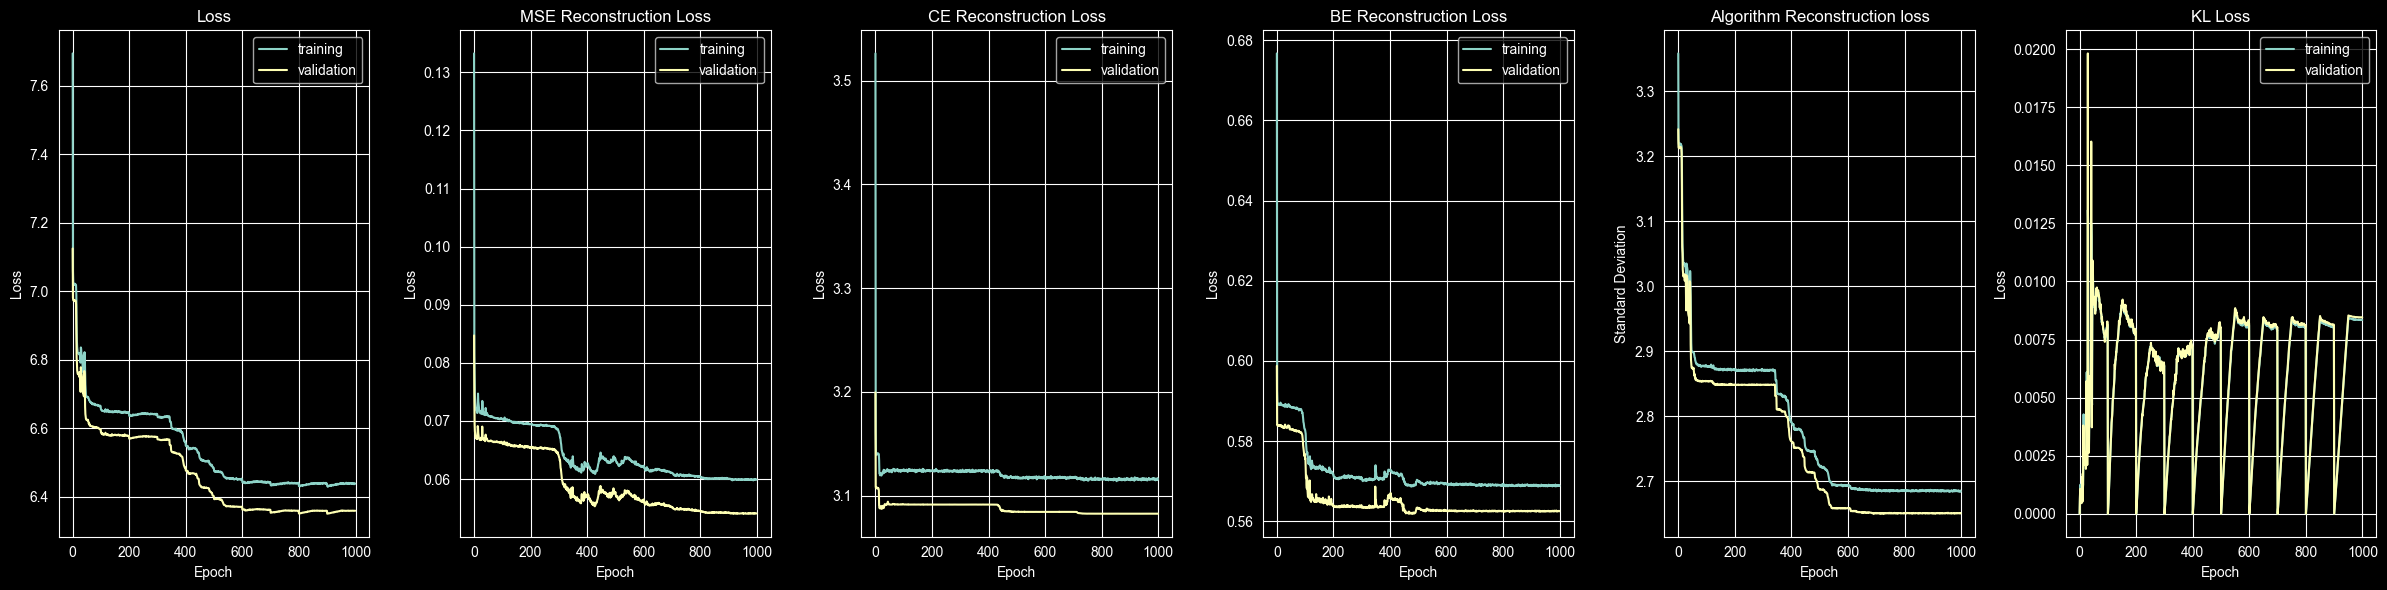

C:\Users\porda\AppData\Local\Temp\ipykernel_6172\2272073894.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32) # also 'gist_ncar' or 'hsv'


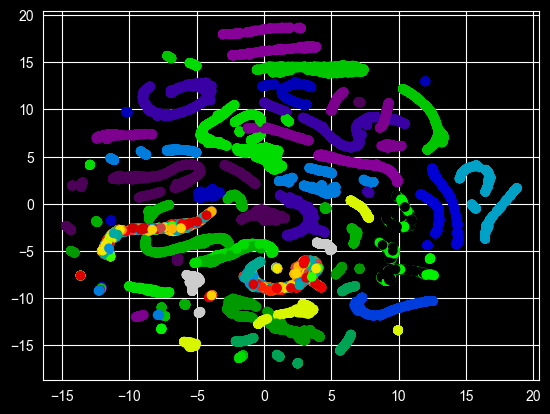

C:\Users\porda\AppData\Local\Temp\ipykernel_6172\2272073894.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32)


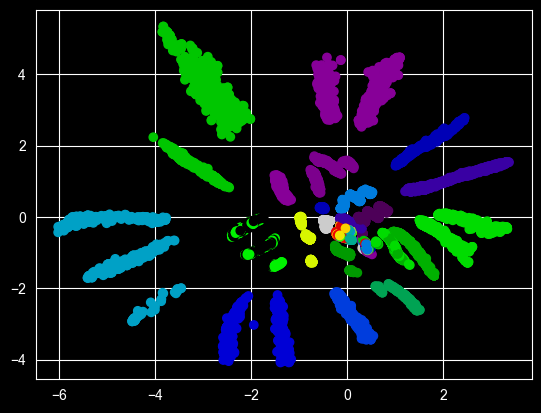

In [50]:
BETA = 0.001
NAME = f"VAE-{LATENT_DIM}-Beta-0-001"
model = VariationalAutoencoder(input_dim=225, output_dim=225, latent_dim=LATENT_DIM)
train_loop(model)

225
204
183
183
162
141
141
120
100
100
79
58
58
37
16
16
37
58
58
79
100
100
120
141
141
162
183
183
204
225
Using GPU
Total samples: 29658
Training samples: 23726
Validation samples: 5932
641734 Parameters
Training VAE...
--------------------------------------------------
Epoch 1/1000 done in 0.5775 seconds
Beta: 0.0000
Learning Rate: 0.00040000
Training Loss: 7.7245
	Training MSE Reconstruction Loss: 0.1359
	Training CE Reconstruction Loss: 3.5574
	Training BE Reconstruction Loss: 0.6686
	Training Algorithm Loss: 3.3626
	Training KL Loss: 0.0000
	Training Total MSE Reconstruction Loss: 0.1705
Validation Loss: 7.1270
	Validation MSE Reconstruction Loss: 0.0921
	Validation CE Reconstruction Loss: 3.2116
	Validation BE Reconstruction Loss: 0.5961
	Validation Algorithm Loss: 3.2272
	Validation KL Loss: 0.0000
	Validation Total MSE Reconstruction Loss: 0.1359
--------------------------------------------------
--------------------------------------------------
Epoch 2/1000 done in 0.3695 

<Figure size 640x480 with 0 Axes>

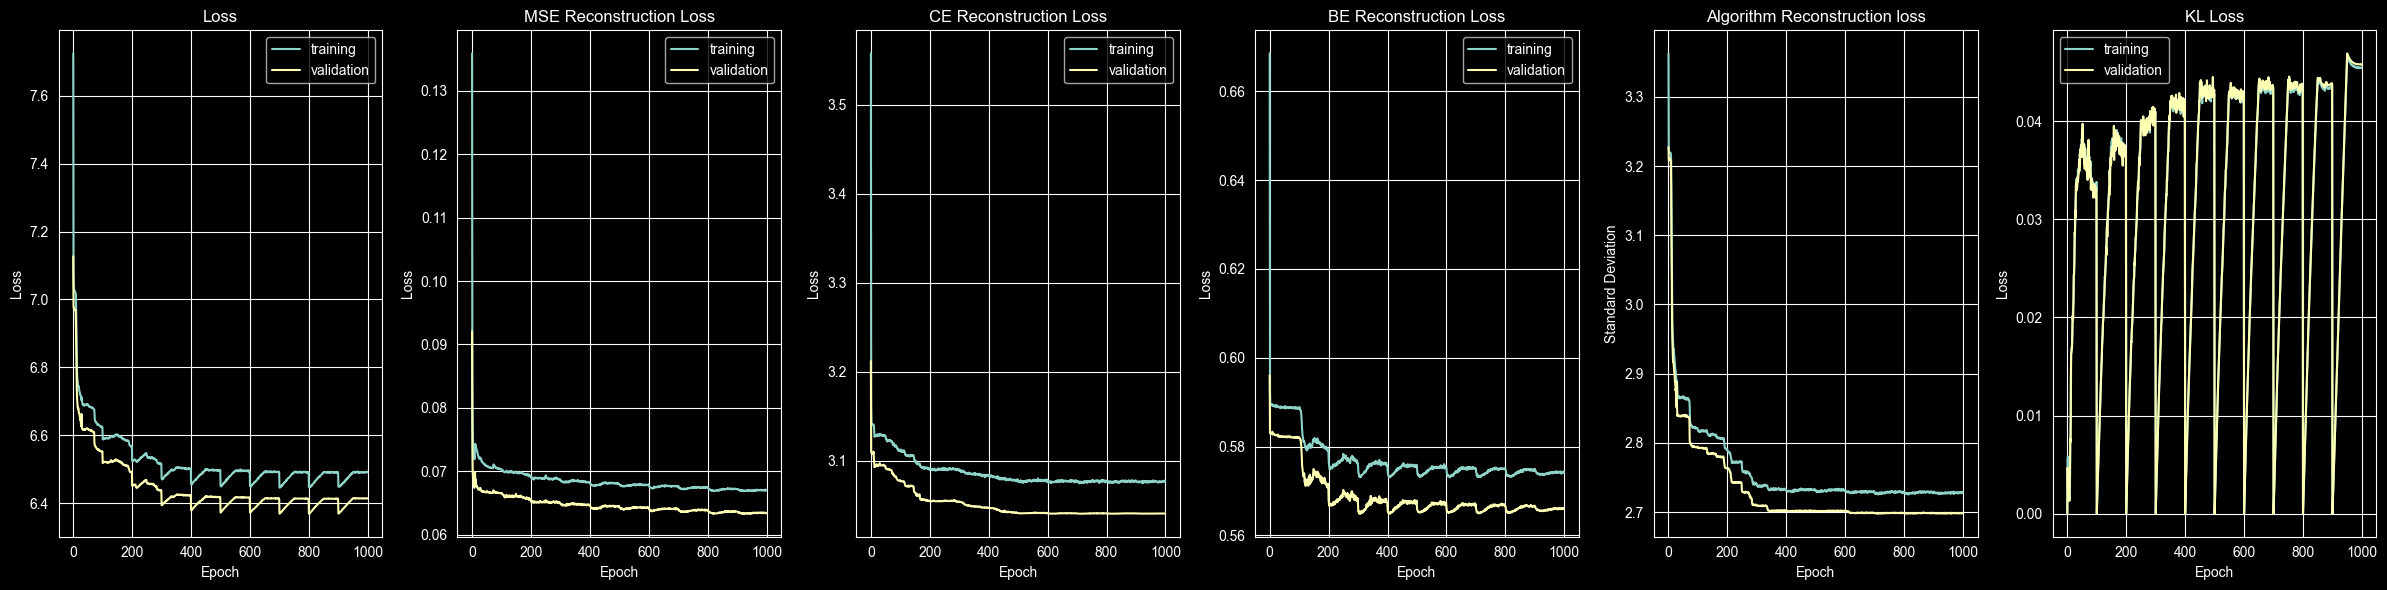

C:\Users\porda\AppData\Local\Temp\ipykernel_6172\2272073894.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32) # also 'gist_ncar' or 'hsv'


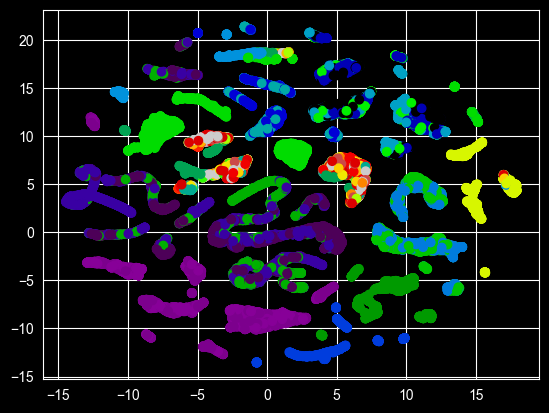

C:\Users\porda\AppData\Local\Temp\ipykernel_6172\2272073894.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32)


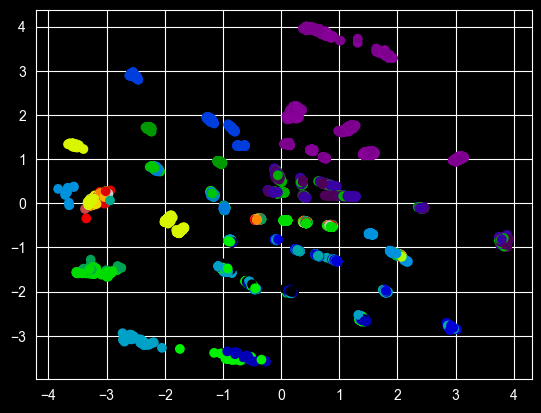

In [51]:
BETA = 0.01
NAME = f"VAE-{LATENT_DIM}-Beta-0-01"
model = VariationalAutoencoder(input_dim=225, output_dim=225, latent_dim=LATENT_DIM)
train_loop(model)

225
204
183
183
162
141
141
120
100
100
79
58
58
37
16
16
37
58
58
79
100
100
120
141
141
162
183
183
204
225
Using GPU
Total samples: 29658
Training samples: 23726
Validation samples: 5932
641734 Parameters
Training VAE...
--------------------------------------------------
Epoch 1/1000 done in 0.5042 seconds
Beta: 0.0000
Learning Rate: 0.00040000
Training Loss: 7.7767
	Training MSE Reconstruction Loss: 0.1357
	Training CE Reconstruction Loss: 3.5643
	Training BE Reconstruction Loss: 0.6995
	Training Algorithm Loss: 3.3772
	Training KL Loss: 0.0000
	Training Total MSE Reconstruction Loss: 0.1717
Validation Loss: 7.1867
	Validation MSE Reconstruction Loss: 0.0892
	Validation CE Reconstruction Loss: 3.2272
	Validation BE Reconstruction Loss: 0.6211
	Validation Algorithm Loss: 3.2492
	Validation KL Loss: 0.0000
	Validation Total MSE Reconstruction Loss: 0.1357
--------------------------------------------------
--------------------------------------------------
Epoch 2/1000 done in 0.5780 

<Figure size 640x480 with 0 Axes>

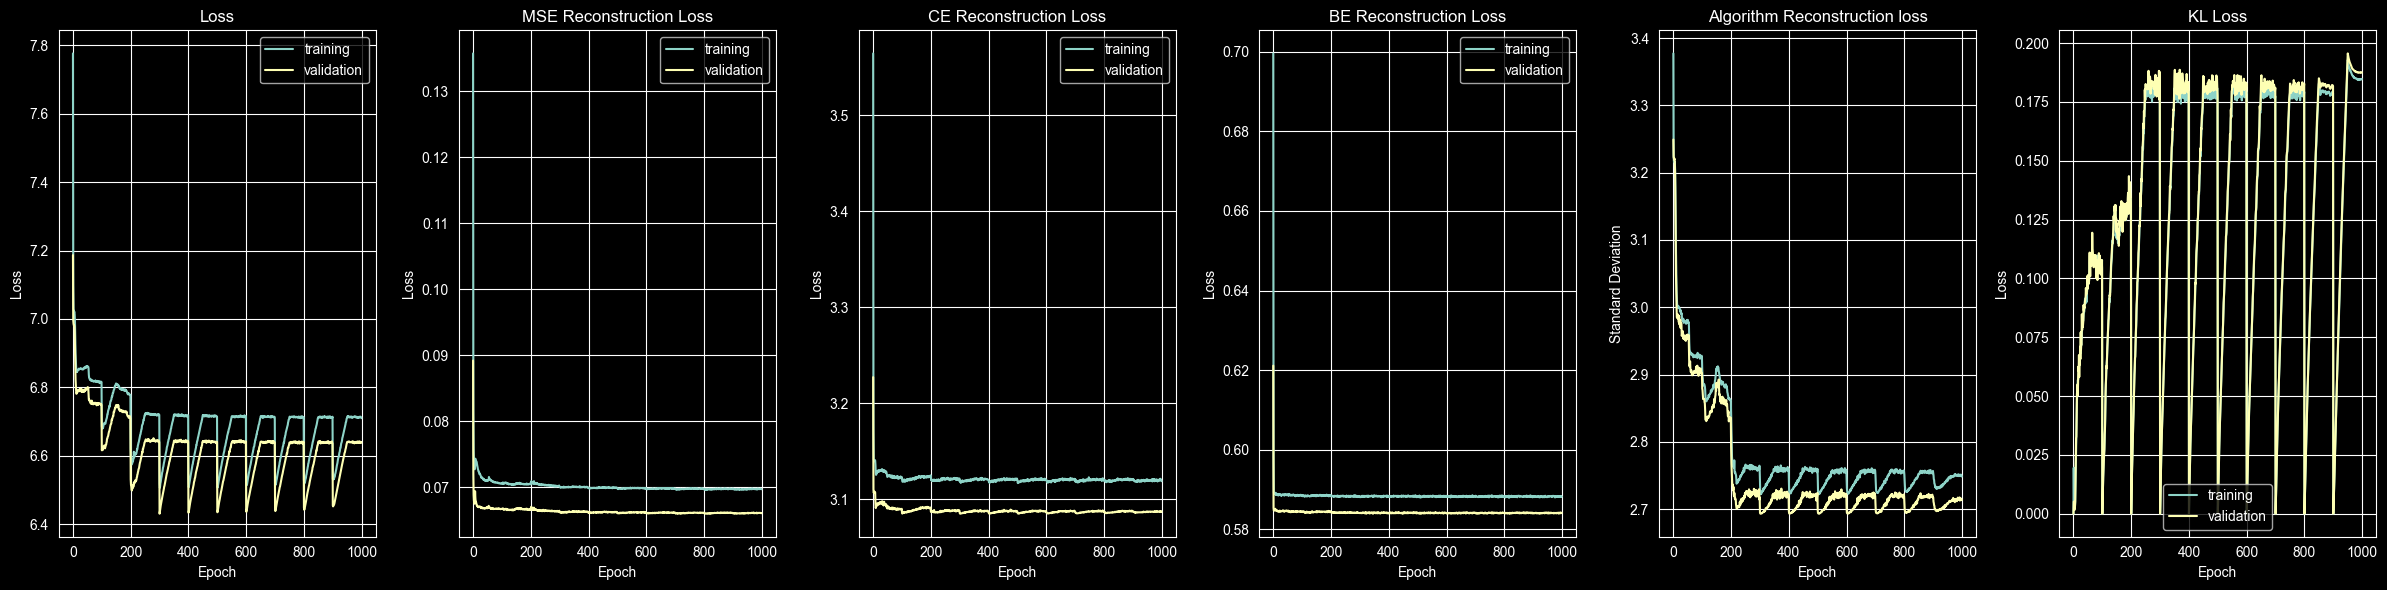

C:\Users\porda\AppData\Local\Temp\ipykernel_6172\2272073894.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32) # also 'gist_ncar' or 'hsv'


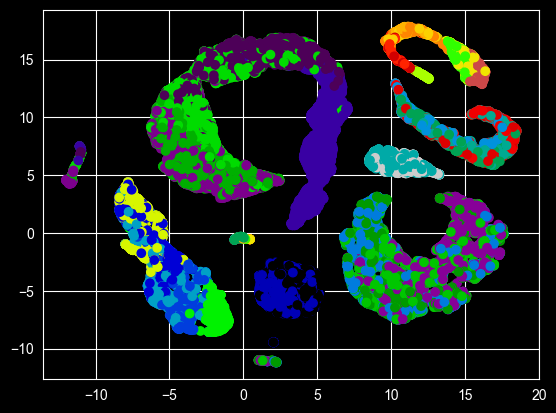

C:\Users\porda\AppData\Local\Temp\ipykernel_6172\2272073894.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32)


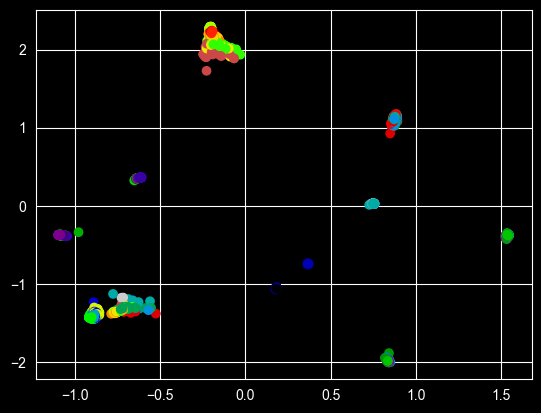

In [52]:
BETA = 0.1
NAME = f"VAE-{LATENT_DIM}-Beta-0-1"
model = VariationalAutoencoder(input_dim=225, output_dim=225, latent_dim=LATENT_DIM)
train_loop(model)

225
204
183
183
162
141
141
120
100
100
79
58
58
37
16
16
37
58
58
79
100
100
120
141
141
162
183
183
204
225
Using GPU
Total samples: 29658
Training samples: 23726
Validation samples: 5932
641734 Parameters
Training VAE...
--------------------------------------------------
Epoch 1/1000 done in 0.5660 seconds
Beta: 0.0000
Learning Rate: 0.00040000
Training Loss: 7.7623
	Training MSE Reconstruction Loss: 0.1322
	Training CE Reconstruction Loss: 3.5695
	Training BE Reconstruction Loss: 0.6841
	Training Algorithm Loss: 3.3765
	Training KL Loss: 0.0000
	Training Total MSE Reconstruction Loss: 0.1695
Validation Loss: 7.1992
	Validation MSE Reconstruction Loss: 0.0862
	Validation CE Reconstruction Loss: 3.2524
	Validation BE Reconstruction Loss: 0.6151
	Validation Algorithm Loss: 3.2455
	Validation KL Loss: 0.0000
	Validation Total MSE Reconstruction Loss: 0.1344
--------------------------------------------------
--------------------------------------------------
Epoch 2/1000 done in 0.3815 

<Figure size 640x480 with 0 Axes>

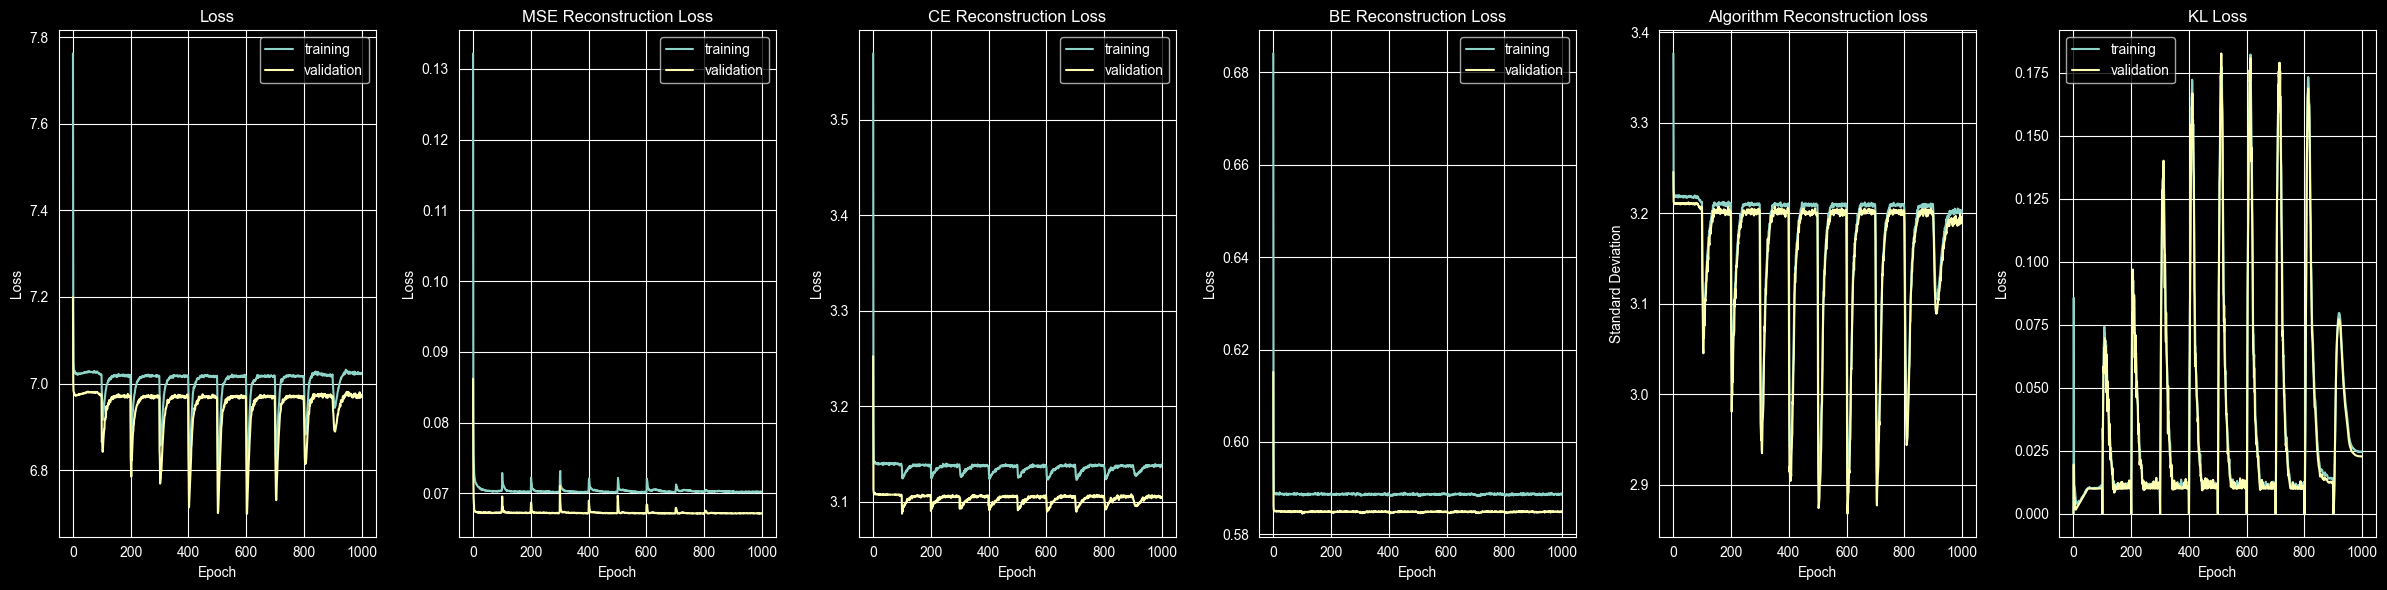

C:\Users\porda\AppData\Local\Temp\ipykernel_6172\2272073894.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32) # also 'gist_ncar' or 'hsv'


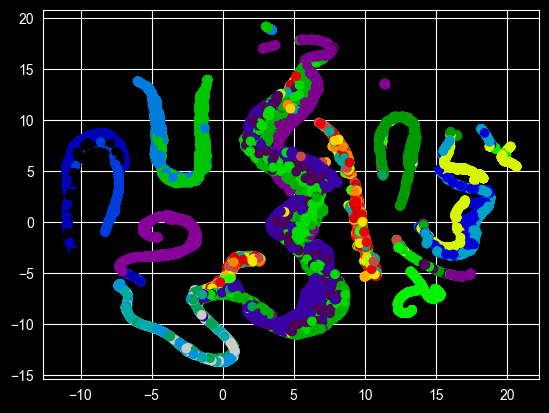

C:\Users\porda\AppData\Local\Temp\ipykernel_6172\2272073894.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 32)


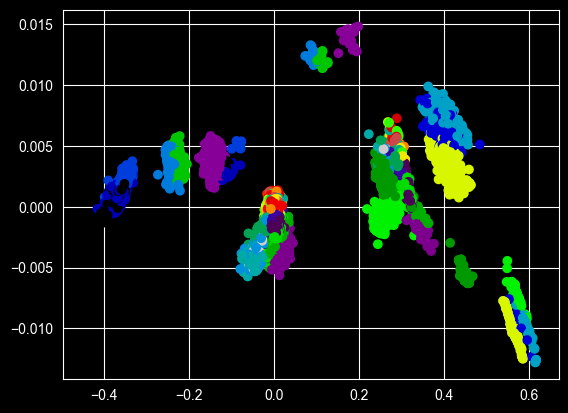

In [53]:
BETA = 1
NAME = f"VAE-{LATENT_DIM}-Beta-1"
model = VariationalAutoencoder(input_dim=225, output_dim=225, latent_dim=LATENT_DIM)
train_loop(model)